# Pre

## Init

In [1]:
import joblib
import os
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import log_loss, confusion_matrix
from scipy.special import expit
from xgboost import XGBRegressor, XGBClassifier
from xgboost.sklearn import XGBModel

from tqdm.auto import tqdm
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 500)

from regression_based_em_V2 import RegressionBasedEM
from regression_based_em_V2_test import XGBoostLearnerWrapper
from regression_based_em_V2_keras import KerasLearnerWrapper

X_columns = np.concatenate([
    [f'user_latent_{i}' for i in range(50)],
    [f'user_history_short_latent_{i}' for i in range(50)],
    [f'user_history_long_latent_{i}' for i in range(50)],
    [f'user_audiences_users_latent_{i}' for i in range(50)],
    [f'user_audiences_genres_latent_{i}' for i in range(50)],
    [f'collection_genres_latent_{i}' for i in range(50)],
    [f'collection_series_latent_{i}' for i in range(50)],
    [f'serie_latent_{i}' for i in range(50)],
    ['user_serie_history']
])


Xpath = '../data_bk/_20191201_20191231.svmlight'
X = f'{Xpath}#{Xpath}.cache'

c_to_gamma = np.array([0.1, 0.5, 0.7, 0.8])

## Load stat

In [2]:
model_names_files = [
    ('GBDT_1', 'V2.model'),
    ('GBDT_3', 'V2_3.model'),
    ('GBDT_5', 'V2_5.model'),
    ('GBDT_10', 'V2_10.model'),
#     ('GBDT_50', 'V2_50.model'),
    
    ('MLP_1', 'learner_keras.model'),
    ('MLP_2', 'learner_keras2.model'),
    
    ('GBDT_10_nogammainit', 'V2_10_nogammainit.model'),
    ('GBDT_5_nogammainit', 'V2_5_nogammainit.model'),
    ('MLP_1_nogammainit','learner_keras_nogammainit.model'),
    
    ('GBDT_1_multiclick', 'V2_1_multiclick.model'),
    ('GBDT_5_multiclick', 'V2_5_multiclick.model'),
    ('GBDT_10_multiclick', 'V2_10_multiclick.model'),
    ('GBDT_50_multiclick', 'V2_50_multiclick.model'),
    
    ('MLP_1_multiclick', 'learner_keras_multiclick.model'),
    
    ('MLP_1_multiclick_long', 'learner_keras_multiclick_long.model'),
    ('MLP_1_long','learner_keras_long.model'),
    
    ('V2_5_nothetaclip', 'V2_5_nothetaclip.model'),
    
    ('GBDT_1_eval', 'V2_1_eval.model'),
    ('GBDT_5_eval', 'V2_5_eval.model'),
    ('GBDT_10_eval', 'V2_10_eval.model'),
    ('MLP_1_eval', 'learner_keras_eval.model'),
    
    ('MLP_1_lr1e-4', 'learner_keras_lr1e-4.model'),
    
    
]

names = [i[0] for i in model_names_files]
losses = {}
thetas = {}

for name, file in model_names_files:
    reg = joblib.load(file)
    
    losses[name] = reg.losses_
    thetas[name] = reg.thetas_

# Result

## Single click vs multi click

### Setup
- The data was composed into 2 datasets with two different flavours:
    - multiclick: each query can have multiple clicked items
    - singleclick: each query is dupplicated and modified so that each new query only contains one single clicked item. The number of new queries is equal to the number of clicked item in the old one.
- Chosen benchmark models are run on the both datasets

### Conclusion
- Across multiple models the fitness (loss) of the single version is consistently better than that of their counterpart
- Moreover, the bias estimations show that the models which used multiclick datasets show no estimation capacity as all the estimation accross positions is almost the same

From this point onwards, without further mention, the dataset used is the singleclick version.

GBDT_1_multiclick
GBDT_5_multiclick
GBDT_10_multiclick
MLP_1_multiclick


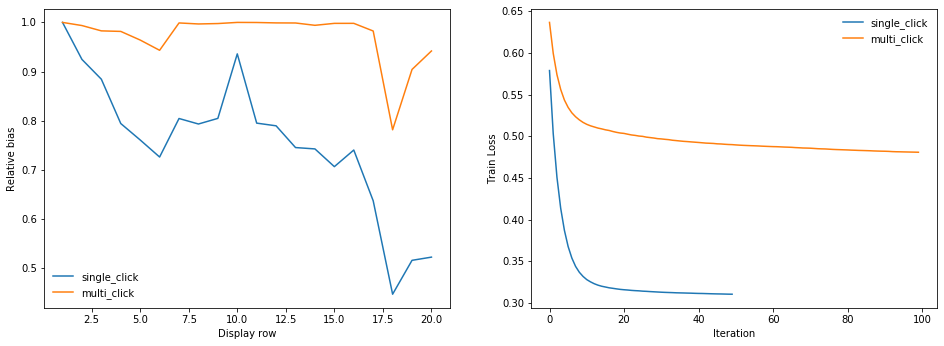

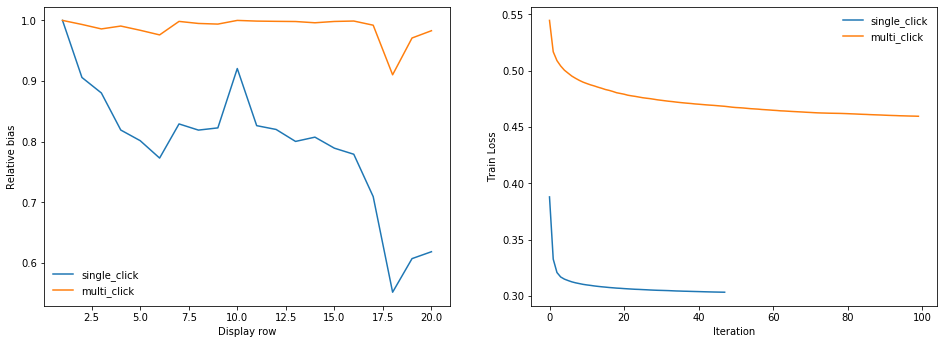

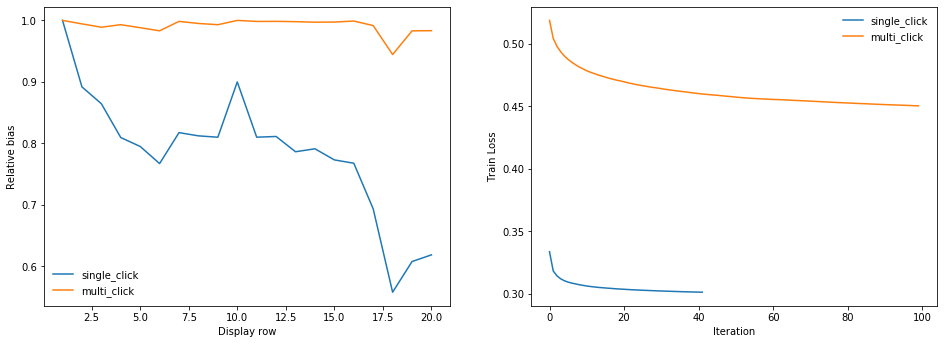

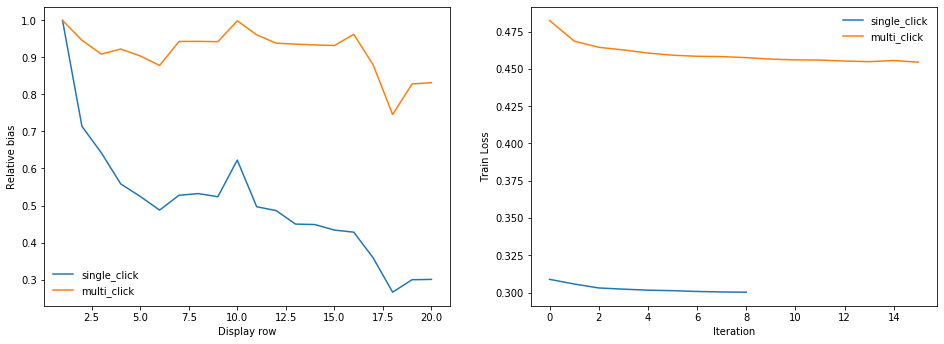

In [50]:
# f, axes = plt.subplots(4,2, figsize=(8,11))

for i, base in enumerate(['GBDT_1', 'GBDT_5', 'GBDT_10', 'MLP_1']):
    
    if base + '_multiclick' not in names:
        print(f'TODO: {base}')
        continue
        
    _names = [base, base + '_multiclick']
    
    f, axes = plt.subplots(1,2, figsize=(8*2,11*2/4))
    
    for name in _names:
        loss = losses[name]
        theta = thetas[name]

        final_theta = theta[-1][:20]

        sns.lineplot(
            x = list(range(1,len(final_theta)+1)),
            y = final_theta,
            ax=axes[0]
        )

        sns.lineplot(
            x=range(len(loss)),
            y=loss,
            ax=axes[1]
        )
    
    axes[0].set_ylabel('Relative bias')
    axes[0].set_xlabel('Display row')
    axes[0].legend(['single_click','multi_click'], frameon=False)
    axes[1].set_ylabel('Train Loss')
    axes[1].set_xlabel('Iteration')
    axes[1].legend(['single_click','multi_click'], frameon=False)
    print(name)

## Bias estimation

- Overall have the same shape although the scale is different
- MLP models have significant lower values for lower bias in compared to GDBT's
- Noises and fluctuation is presented from around the 20th display row due to lack of data (not many collections can span more than 20 rows)
- The sudden rise at row 11th is maybe due to the dataset.

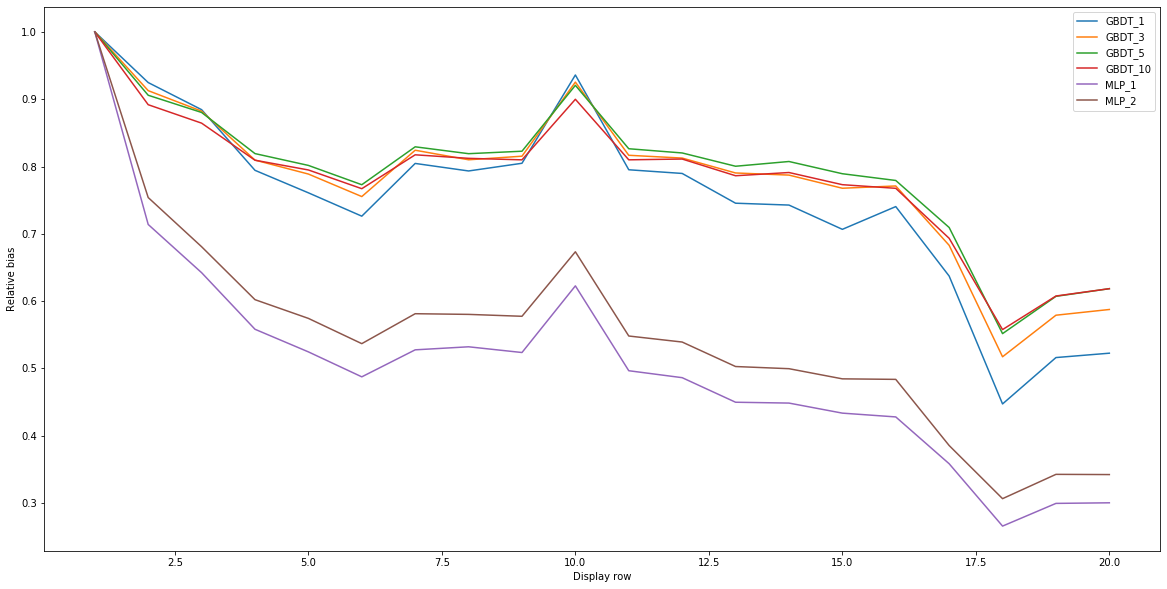

In [52]:
f, a = plt.subplots(1,1, figsize=(20,10))
_names = []
for i, (name, theta) in enumerate(thetas.items()):
    if 'nogammainit' in name or 'multiclick' in name or 'long' in name or 'notheta' in name or 'eval' in name or 'lr' in name:
        continue

    final_theta = theta[-1][:20]
    
    sns.lineplot(
        x = list(range(1,len(final_theta)+1)),
        y = final_theta,
        ax=a
    )
    _names.append(name)
a.set_ylabel('Relative bias')
a.set_xlabel('Display row')
a.legend(_names)

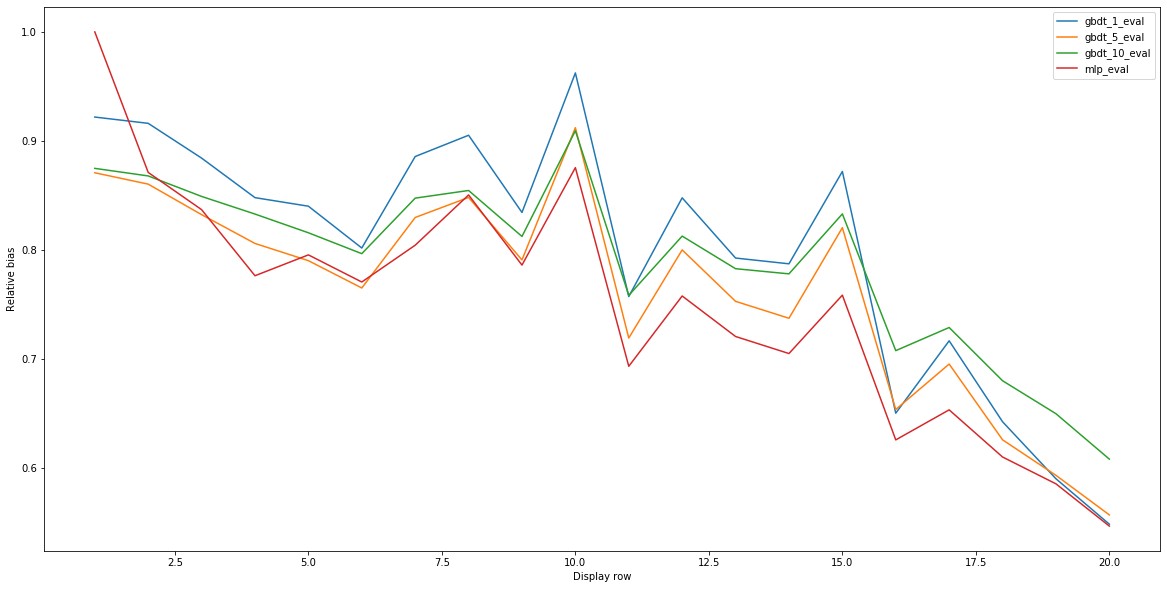

In [4]:
f, a = plt.subplots(1,1, figsize=(20,10))
_names = []
for i, (name, theta) in enumerate(thetas.items()):
    if 'eval' not in name:
        continue

    final_theta = theta[-1][:20]
    
    sns.lineplot(
        x = list(range(1,len(final_theta)+1)),
        y = final_theta,
        ax=a
    )
    _names.append(name)
a.set_ylabel('Relative bias')
a.set_xlabel('Display row')
a.legend(_names)

## Data fitness

- The models were trained with early stopping at the tolerance of 5 iterations.
- 2 MLP models fit the initial label too well but show no adapting capability for later adjusments (inceasing loss) thus being stopped at early iterations. (will revisit)
- At the end of t-th iteration, the label is recalulated based on the bias estimation, which in turn is depend on the (t-1)-th model. In other words, the higher the number of trees per iteration, the more fit the model is to the *current* bias estimation. Thus a better fit between GBDT models could suggests an overfit on earlier iterations, which leaves no room for later bias adjusting
- The original paper used gdbt_1 without mentioning of this hyperparameter.

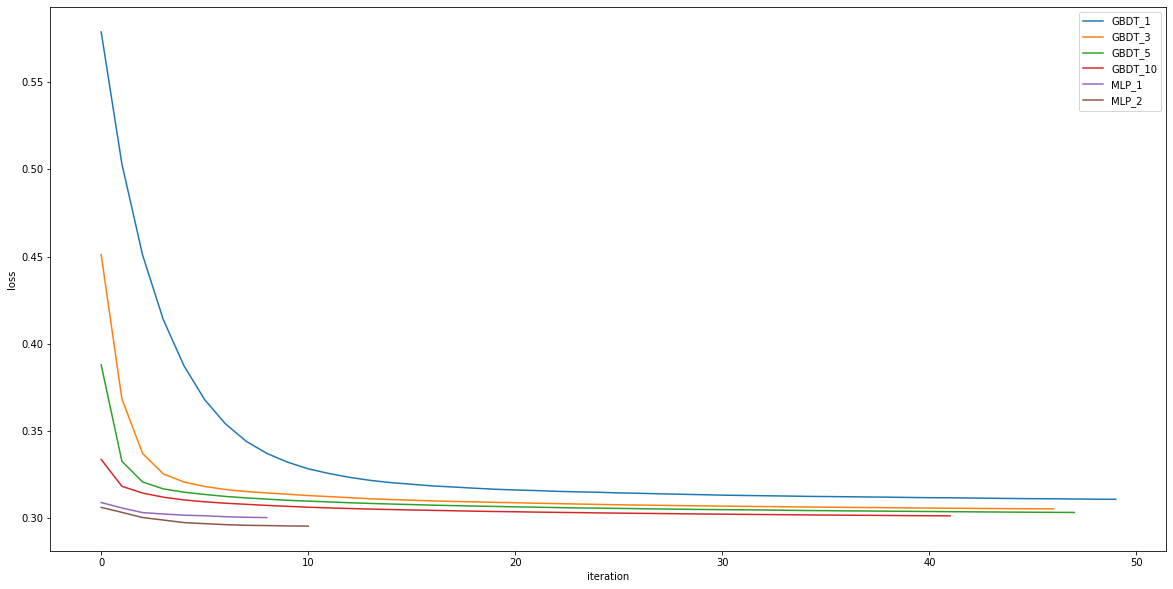

In [53]:
f, a = plt.subplots(1,1, figsize=(20,10))
_names = []
for i,(name, loss) in enumerate(losses.items()):
    if 'nogammainit' in name or 'multiclick' in name or 'long' in name or 'notheta' in name or 'eval' in name or 'lr' in name:
        continue
    
    sns.lineplot(
        x=range(len(loss)),
        y=loss
    )
    _names.append(name)
a.set_ylabel('loss')
a.set_xlabel('iteration')
a.legend(_names)

{'gbdt_1': 0.3107410282406458,
 'gbdt_3': 0.305266773904683,
 'gbdt_5': 0.3032044853418377,
 'gbdt_10': 0.301245528215628,
 'mlp': 0.3002615700656724,
 'mlp2': 0.29537609001434795}

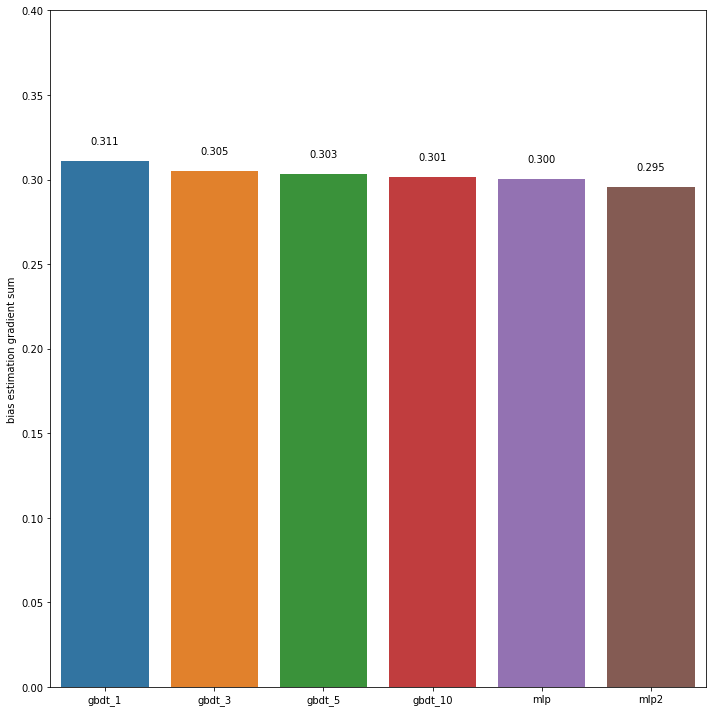

In [19]:
f, a = plt.subplots(1,1, figsize=(10,10))
d = {k:v[-1] for k,v in losses.items() if not ('nogammainit' in k or 'multiclick' in k or 'long' in k or 'notheta' in k or 'eval' in k)}
display(d)
sns.barplot(
    data=pd.DataFrame(d, index=[0]),
    ax=a
)
for i, (name, val) in enumerate(d.items()):
    a.text(i,val+.01, '{:.3f}'.format(val), color='black', ha="center")
a.set_ylabel('bias estimation gradient sum')
a.set_ylim(0,0.4)
f.tight_layout()

## Bias estimation convergence

Bias estimation value changes by position of display row

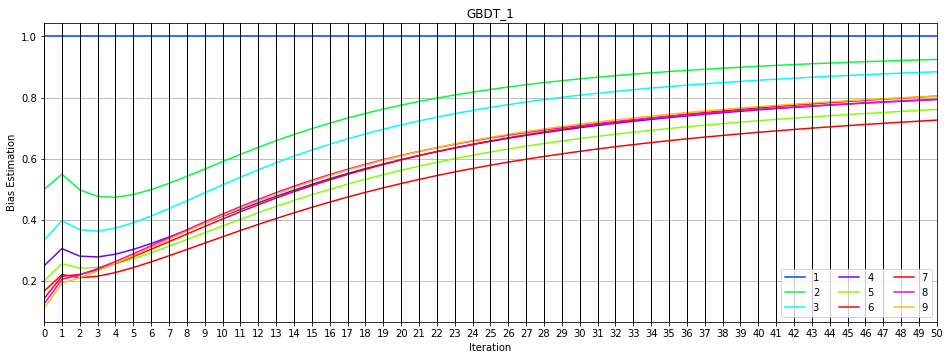

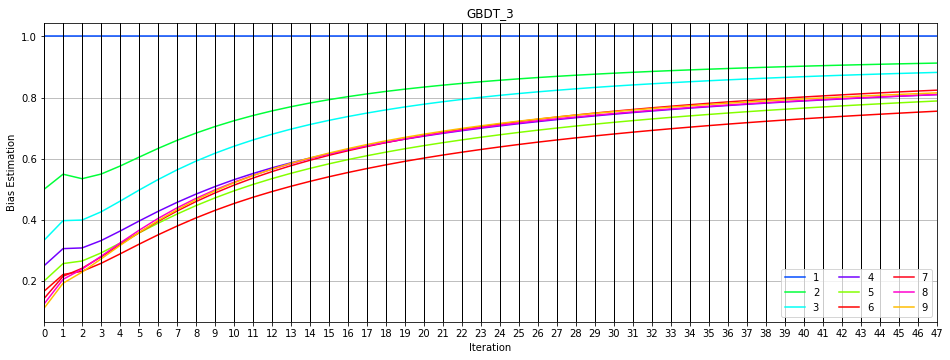

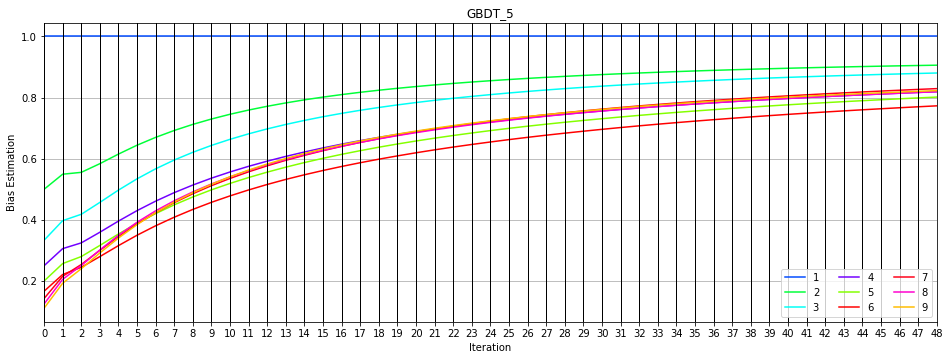

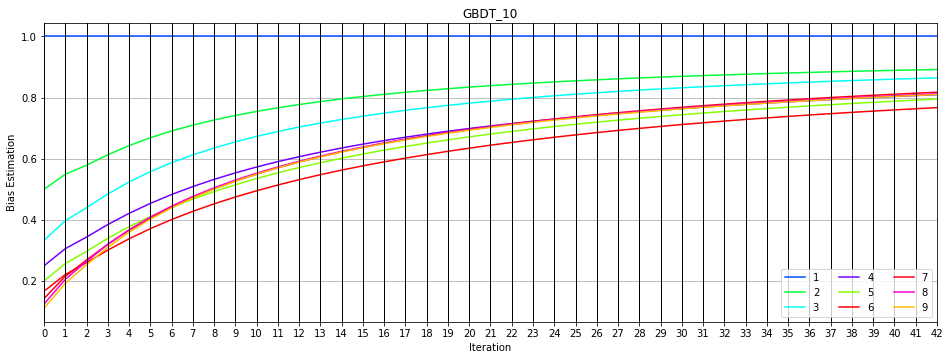

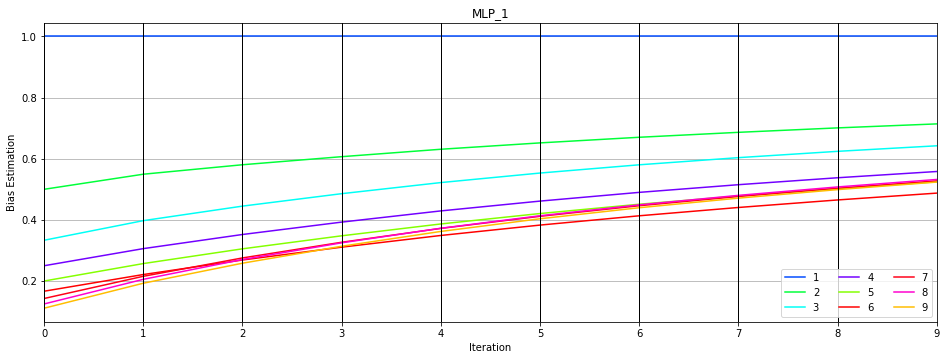

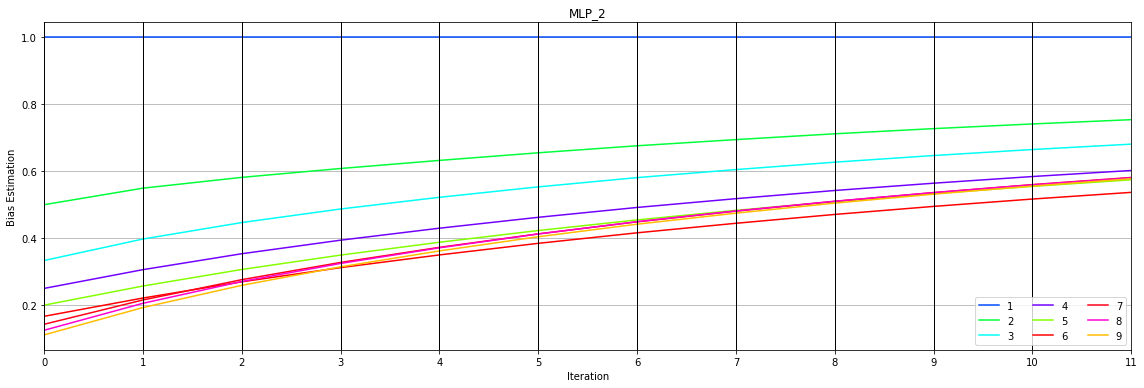

In [64]:
i = 0
theta_last_gradient = {}
for name, l in thetas.items():
    if 'nogammainit' in name or 'multiclick' in name or 'long' in name or 'notheta' in name or 'eval' in name or 'lr' in name:
        continue
        
    f, a = plt.subplots(1,1, figsize=(8*2,11*2/4),)
    pd.plotting.parallel_coordinates(
        pd.DataFrame(np.array(l).T[:9]).reset_index(), 
        'index',
        sort_labels=True,
        colormap='hsv',
        ax=a
    )
        
    a.set_ylabel('Bias Estimation')
    a.set_xlabel('Iteration')
    a.legend(range(1,10), loc='lower right', ncol=3)
    a.set_title(name)
    
    i += 1
    
f.tight_layout()

- Using gradients to quantify the convergence of bias estimation
- The line graphs are the gradients of the previous graphs
- The bar graphs are the sum of bias estimation gradients from the last 3 iterations, only considering the top 20 positions
- gdbt_5 has the lowest value. this suggests 5 trees per iteration gives the most stable (credible?) estimation

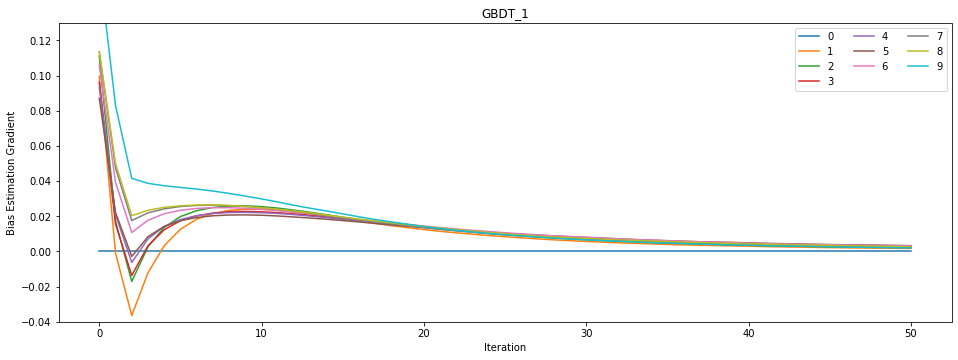

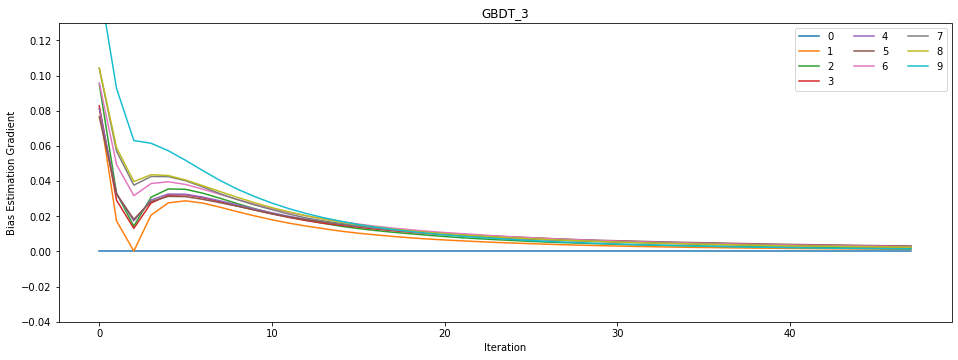

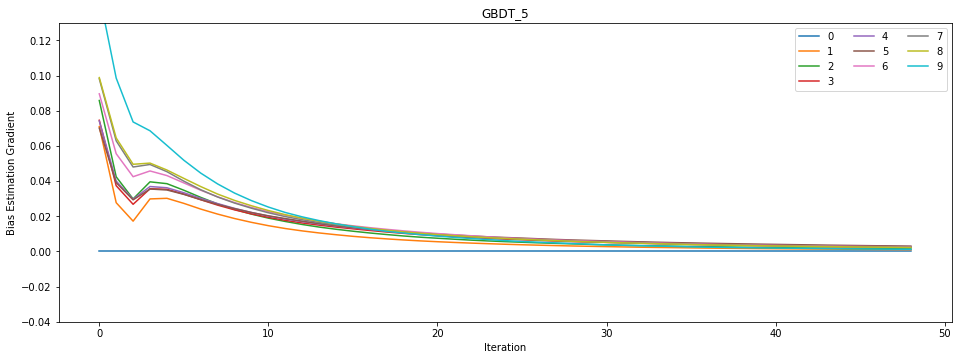

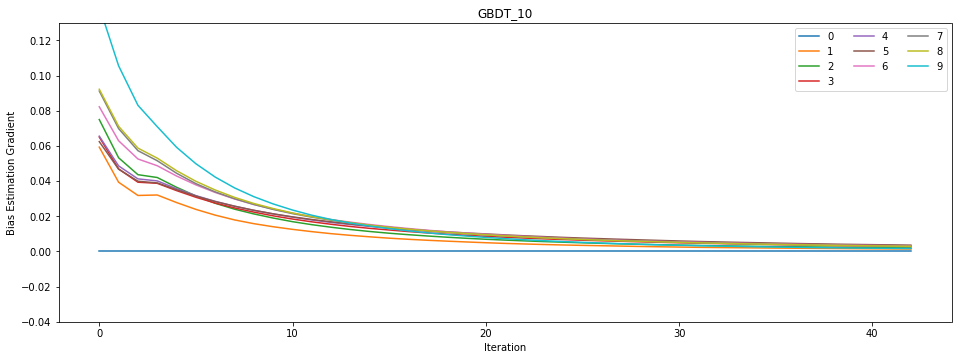

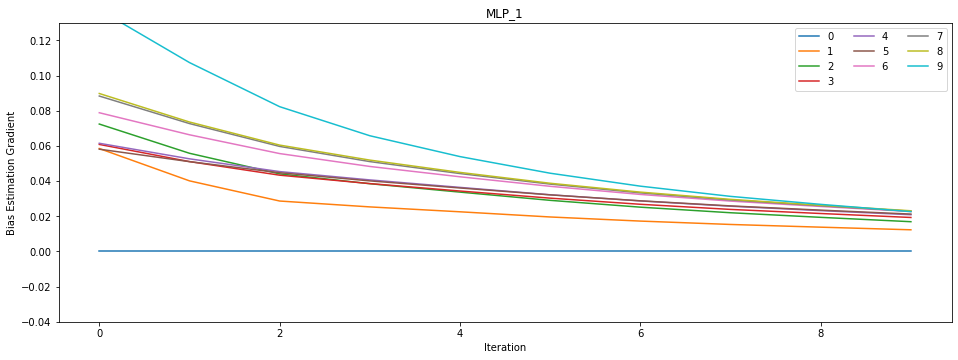

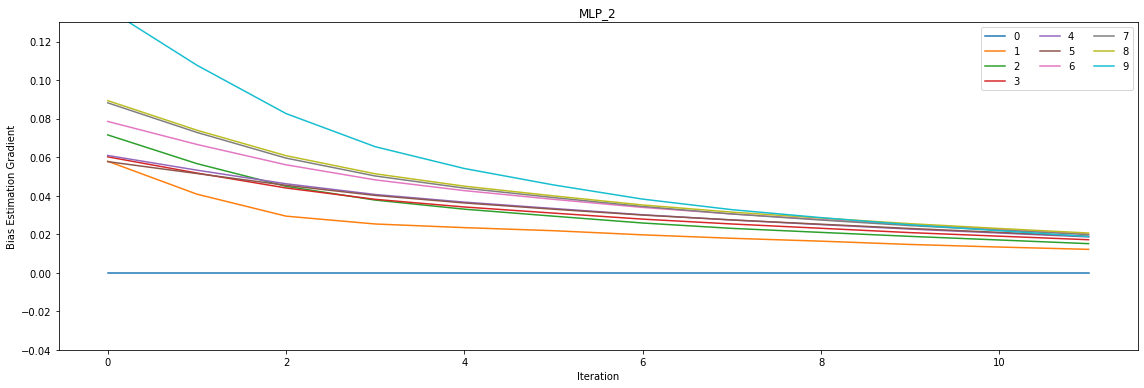

In [72]:
i = 0
theta_last_gradient_1 = {}
theta_last_gradient_3 = {}
for name, l in thetas.items():
    if 'nogammainit' in name or 'multiclick' in name or 'long' in name or 'notheta' in name or 'eval' in name or 'lr' in name:
        continue
        
    f, a = plt.subplots(1,1, figsize=(8*2,11*2/4),)
        
    t = np.array(l).T
    tt = np.gradient(t, axis=1,edge_order=2)
    for ii in range(len(tt))[:10]:
        sns.lineplot(
            x=range(len(tt[ii])),
            y=tt[ii],
            ax = a
        )
        
    a.set_ylabel('Bias Estimation Gradient')
    a.set_xlabel('Iteration')
    a.set_ylim(-0.040, 0.130)
    a.legend(range(10), loc='upper right', ncol=3)
    a.set_title(name)
    
    theta_last_gradient_1[name] = np.sum(tt[:,-1:],axis=1)
    theta_last_gradient_3[name] = np.sum(tt[:,-3:],axis=1)
    
    i += 1
f.tight_layout()

{'GBDT_1': 0.06235044327052586,
 'GBDT_3': 0.05951910856370768,
 'GBDT_5': 0.05536234950759389,
 'GBDT_10': 0.06658803780491518,
 'MLP_1': 0.40388747005877235,
 'MLP_2': 0.3598279695732682}

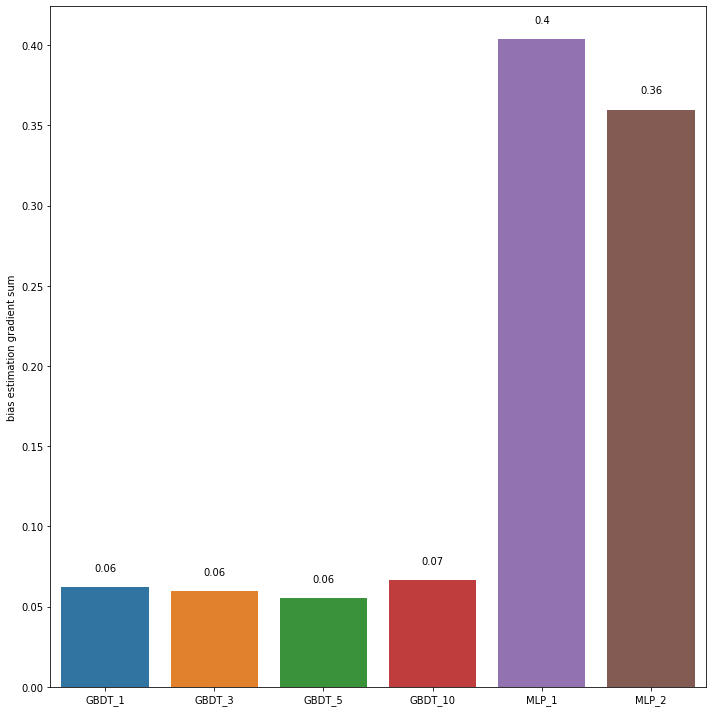

In [68]:
f, a = plt.subplots(1,1, figsize=(10,10))
d = {k:sum(v[:20]) for k,v in theta_last_gradient_1.items()}
sns.barplot(
    data=pd.DataFrame(d, index=[0]),
    ax=a
)
for i, (name, val) in enumerate(d.items()):
    a.text(i,val+.01, round(val,2), color='black', ha="center")
a.set_ylabel('bias estimation gradient sum')
f.tight_layout()
d

In [69]:
f, a = plt.subplots(1,1, figsize=(10,10))
d = {k:sum(v[:20]) for k,v in theta_last_gradient_3.items()}
sns.barplot(
    data=pd.DataFrame(d, index=[0]),
    ax=a
)
for i, (name, val) in enumerate(d.items()):
    a.text(i,val+.01, round(val,2), color='black', ha="center")
a.set_ylabel('bias estimation gradient sum')
f.tight_layout()
d

{'GBDT_1': 0.19395213266226546,
 'GBDT_3': 0.18510631865394422,
 'GBDT_5': 0.17212559802266564,
 'GBDT_10': 0.20788448372197194,
 'MLP_1': 1.35574185077952,
 'MLP_2': 1.1910828747015985}

## Dwell value as aid

In this part, we also survey the importance of the usage of dwell rating (additional rating based on manga_view, chapter_read,...) as intial esimation aid on top of the 1/0 label. 

More in depth, in the normal setup, the initial distribution of the true relevance is pre-estimated by the dwell value. Then is iteratively updated.

For the nogammainit value, the initial distribution of the relevance is the 1/0 click label.

The original paper used 1/0 click label as the initial.

Dwell value distribution and the initial distribution from it:

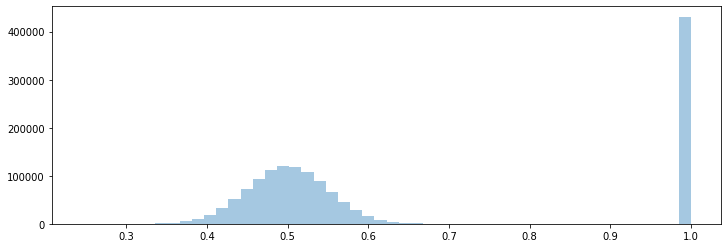

In [81]:
X_c = np.load('../data_bk/_single_click_20191201_20191231.X_c.npy', allow_pickle=True)
X_c[X_c > 1] = 2
gamma0 = np.array([0, 0.5, 1]).take(X_c)
gamma0[X_c==1] = (gamma0 + np.random.normal(0, 0.05, gamma0.shape))[X_c==1]
gamma0 = np.clip(gamma0, 0, 1)

f, a = plt.subplots(1,1, figsize=(12,4),)
sns.distplot(X_c[X_c > 0], ax=a)
f, a = plt.subplots(1,1, figsize=(12,4),)
sns.distplot(gamma0[X_c > 0], kde=False, ax=a)

- The line graphs are the gradients of the bias estimation through time.
- The bar graphs are the sum of bias estimation gradients from the last 3 iterations, only considering the top 20 positions
- Overall, we can draw a conclusion is that initializing the relevance by additional information (dwell value) can indeed helps with the training process.

In [114]:
f, a = plt.subplots(3,2, figsize=(20,10))
a = list(itertools.chain.from_iterable(a))

theta_last_gradient_1 = {}
theta_last_gradient_3 = {}
for i, name in enumerate(['GBDT_5', 'GBDT_5_nogammainit', 'GBDT_10', 'GBDT_10_nogammainit', 'MLP_1', 'MLP_1_nogammainit']):
    l = thetas[name]
    
    if name == 'MLP_1_nogammainit':
        l = l[:9]
        
    t = np.array(l).T
    tt = np.gradient(t, axis=1,edge_order=2)
    for ii in range(len(tt))[:10]:
        sns.lineplot(
            x=range(len(tt[ii])),
            y=tt[ii],
            ax = a[i]
        )
        
    a[i].set_ylabel('bias estimation gradient')
    a[i].set_xlabel('iteration')
    a[i].set_ylim(-0.040, 0.130)
    a[i].legend(range(10), loc='upper right', ncol=3)
    a[i].set_title(name)
    
    theta_last_gradient_1[name] = np.sum(tt[:,-1:],axis=1)
    theta_last_gradient_3[name] = np.sum(tt[:,-3:],axis=1)
f.tight_layout()

{'GBDT_5': 0.05536234950759389,
 'GBDT_5_nogammainit': 0.06421712125550139,
 'GBDT_10': 0.06658803780491518,
 'GBDT_10_nogammainit': 0.06746073797001195,
 'MLP_1': 0.40388747005877235,
 'MLP_1_nogammainit': 0.43461567114436783}

array([0.        , 0.15994212, 0.20276756, 0.21853098, 6.29534555,
       6.85038343])

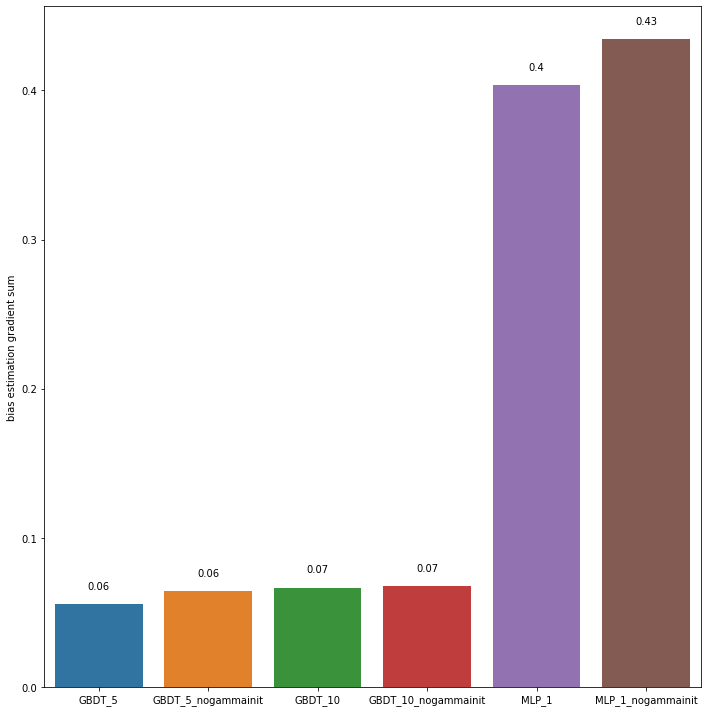

In [115]:
f, a = plt.subplots(1,1, figsize=(10,10))
d = {k:sum(v[:20]) for k,v in theta_last_gradient_1.items()}
sns.barplot(
    data=pd.DataFrame(d, index=[0]),
    ax=a
)
for i, (name, val) in enumerate(d.items()):
    a.text(i,val+.01, round(val,2), color='black', ha="center")
a.set_ylabel('bias estimation gradient sum')
f.tight_layout()
display(d)
dd = np.array([*d.values()])
display((dd - min(dd)) / min(dd))

In [116]:
f, a = plt.subplots(1,1, figsize=(10,10))
d = {k:sum(v[:20]) for k,v in theta_last_gradient_3.items()}
sns.barplot(
    data=pd.DataFrame(d, index=[0]),
    ax=a
)
for i, (name, val) in enumerate(d.items()):
    a.text(i,val+.01, round(val,2), color='black', ha="center")
a.set_ylabel('bias estimation gradient sum')
f.tight_layout()
display(d)
dd = np.array([*d.values()])
display((dd - min(dd)) / min(dd))

{'GBDT_5': 0.17212559802266564,
 'GBDT_5_nogammainit': 0.1989395523025979,
 'GBDT_10': 0.20788448372197194,
 'GBDT_10_nogammainit': 0.2097116603993297,
 'MLP_1': 1.35574185077952,
 'MLP_1_nogammainit': 1.475334526165197}

array([0.        , 0.15578133, 0.2077488 , 0.21836416, 6.8764685 ,
       7.57126739])

In [118]:
f, a = plt.subplots(1,1, figsize=(15,5))

d = {k:v[-1] for k,v in losses.items() if k in ['GBDT_5', 'GBDT_5_nogammainit', 'GBDT_10', 'GBDT_10_nogammainit', 'MLP_1', 'MLP_1_nogammainit']}
a = sns.barplot(
    data=pd.DataFrame(d, index=[0]),
    order=['GBDT_5', 'GBDT_5_nogammainit', 'GBDT_10', 'GBDT_10_nogammainit', 'MLP_1', 'MLP_1_nogammainit']
)
a.set_ylabel('bias estimation gradient sum')
a.set_ylim(0.15)
for i, (name, val) in enumerate(d.items()):
    a.text(i,val+.001, round(val,3), color='black', ha="center")
pd.DataFrame(d, index=[0]),

(     GBDT_5   GBDT_10     MLP_1  GBDT_10_nogammainit  GBDT_5_nogammainit  \
 0  0.303204  0.301246  0.300262             0.301696             0.30371   
 
    MLP_1_nogammainit  
 0           0.298893  ,)

In [14]:
f, a = plt.subplots(1,1, figsize=(15,5))
d = {k:sum(v[:20]) for k,v in theta_last_gradient.items()}
a = sns.barplot(
    data=pd.DataFrame(d, index=[0]),
)
a.set_ylabel('bias estimation gradient sum')
a.set_ylim(0.15)
for i, (name, val) in enumerate(d.items()):
    a.text(i,val+.001, round(val,3), color='black', ha="center")

# eval
The eval result does not really make sense in this scenario because of the lack of real unbiased label
A high enough value would be considered okay and implies the absence of overfitting

In [28]:
valpath = '../data_bk/_20200101_20200107.svmlight'
dval = xgb.DMatrix(f"{valpath}#{valpath}.cache", feature_names=X_columns)
qid_val = np.load('../data_bk/_20200101_20200107.qid.npy', allow_pickle=True)
X_c_val = np.load('../data_bk/_20200101_20200107.X_c.npy', allow_pickle=True)
X_k_val = np.load('../data_bk/_20200101_20200107.X_k.npy', allow_pickle=True)

[12:42:29] 1457498x401 matrix with 484910893 entries loaded from ../data_bk/_20200101_20200107.svmlight#../data_bk/_20200101_20200107.svmlight.cache


In [128]:
from rank_metrics import ndcg_score, mean_average_precision_score

ndcg = {}
y_val = dval.get_label()

for i, (name, f) in enumerate(model_names_files):
    if 'nogammainit' in name or 'mlp' in name:
        continue
    if name == 'mlp':
        continue 
        
    reg = joblib.load(f)
    
    preds = reg.learner.model.predict(dval, validate_features=False)
    
    ndcg_val = ndcg_score(y_val, preds, qid_val, verbose=1, n_jobs=-2)
    ndcg[name] = ndcg_val

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  43 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-2)]: Done 9136 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-2)]: Done 26136 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-2)]: Done 49936 tasks      | elapsed:   42.3s
[Parallel(n_jobs=-2)]: Done 80536 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-2)]: Done 117936 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-2)]: Done 162136 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-2)]: Done 213136 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-2)]: Done 263554 out of 263554 | elapsed:  3.7min finished
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done 782 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-2)]: Done 10982 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-2)]: Done 27982 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-2)]: Done 51782 tasks      | elapsed:   43.0s
[Para

In [129]:
ndcg['baseline_default_order'] = 0.5780386977383033
ndcg['baseline_lambdamart'] = 0.6179909727567925
ndcg

{'gbdt_1': 0.7416871284681303,
 'gbdt_3': 0.7510701778137259,
 'gbdt_5': 0.7581721140420407,
 'gbdt_10': 0.7555899773530217,
 'gbdt_50': 0.7867048532503432,
 'baseline_default_order': 0.5780386977383033,
 'baseline_lambdamart': 0.6179909727567925}

In [32]:
valpath = '../data_bk/_single_click_20200101_20200107.svmlight'
dval = xgb.DMatrix(f"{valpath}#{valpath}.cache", feature_names=X_columns)
qid_val = np.load('../data_bk/_single_click_20200101_20200107.qid.npy', allow_pickle=True)
X_c_val = np.load('../data_bk/_single_click_20200101_20200107.X_c.npy', allow_pickle=True)
X_k_val = np.load('../data_bk/_single_click_20200101_20200107.X_k.npy', allow_pickle=True)

[09:48:13] 3633911x401 matrix with 1213179323 entries loaded from ../data_bk/_single_click_20200101_20200107.svmlight#../data_bk/_single_click_20200101_20200107.svmlight.cache


In [33]:
from rank_metrics import w_mrr_score

y_val = dval.get_label()

chosen_theta = np.insert(thetas['gbdt_5'][-1],0,1)
chosen_theta

array([1.        , 1.        , 0.9058912 , 0.88033583, 0.81920949,
       0.80165724, 0.77296327, 0.82928176, 0.81908535, 0.82274359,
       0.92062936, 0.82641792, 0.82016614, 0.80042506, 0.80746852,
       0.78930086, 0.77927822, 0.70940731, 0.551747  , 0.6071552 ,
       0.61851855, 0.60237649, 0.65727007, 0.65486079, 0.64923516,
       0.70878414, 0.58903686, 0.61846171, 0.74350891, 0.68179185,
       0.73205991, 0.65754695, 0.70652153, 0.53340723, 0.51141024,
       0.71346423, 0.53526786, 0.44891485, 0.74249911, 0.75551654,
       0.72839065, 0.65476233, 0.35541435, 0.798274  , 0.74735118,
       0.78284547, 0.57955961, 0.33466436, 0.21215674, 0.3279671 ,
       0.31724355, 0.12231871, 0.72942877, 0.47415611, 0.4058403 ,
       0.70083086, 0.2185347 , 0.55643009, 0.68719839, 0.80558169,
       0.00223513, 0.70534769, 0.59164258, 0.00206142, 0.84069608,
       0.95196572, 0.00236988, 0.99773996, 0.00264991])

In [29]:
mrr = {'gbdt_1': 0.5017983605564009,
 'gbdt_3': 0.5043852118184724,
 'gbdt_5': 0.5097191925929273,
 'gbdt_10': 0.5061435930104935,
 'gbdt_1_multiclick': 0.5054117030739305,
 'mlp': 0.5237415046001944,
 'mlp2': 0.5241267093372168}

In [9]:
for i, (name, f) in enumerate(model_names_files):
    if 'nogammainit' in name or 'mlp' in name or 'multiclick' in name or name in mrr.keys():
        continue
        
    reg = joblib.load(f)
    
    preds = reg.learner.model.predict(dval, validate_features=False)
    
    mrr_val = w_mrr_score(y_val, preds, chosen_theta, qid_val, verbose=1, n_jobs=-2)
    mrr[name] = mrr_val
    print(name, mrr[name])

In [10]:
mrr

{'gbdt_1': 0.5017983605564009,
 'gbdt_3': 0.5043852118184724,
 'gbdt_5': 0.5097191925929273,
 'gbdt_10': 0.5061435930104935,
 'gbdt_1_multiclick': 0.5054117030739305}

In [29]:
mrr_2 = {'gbdt_1': 0.5072621303619835,
 'gbdt_3': 0.5062222054008414,
 'gbdt_5': 0.5097191925929273,
 'gbdt_10': 0.5082083306239048,
 'mlp': 0.5923368680877008,
 'mlp2': 0.5788411930309484}

In [13]:
for i, (name, f) in enumerate(model_names_files):
    if 'nogammainit' in name or 'mlp' in name or 'multiclick' in name or name in mrr_2.keys():
        continue 
        
    reg = joblib.load(f)
    
    preds = reg.learner.model.predict(dval, validate_features=False)
    
    chosen_theta = np.insert(thetas[name][-1],0,1)
    
    mrr_val = w_mrr_score(y_val, preds, chosen_theta, qid_val, verbose=1, n_jobs=-2)
    mrr_2[name] = mrr_val
    print(name, mrr[name])

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  38 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-2)]: Done 1994 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-2)]: Done 5494 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-2)]: Done 10394 tasks      | elapsed:   26.5s
[Parallel(n_jobs=-2)]: Done 16694 tasks      | elapsed:   42.1s
[Parallel(n_jobs=-2)]: Done 24394 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-2)]: Done 33494 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-2)]: Done 43994 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-2)]: Done 55894 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-2)]: Done 69194 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-2)]: Done 83894 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-2)]: Done 99994 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-2)]: Done 117494 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-2)]: Done 136394 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-2)]: Done 15

gbdt_1 0.5017983605564009


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done 270 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-2)]: Done 2970 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-2)]: Done 7470 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-2)]: Done 13770 tasks      | elapsed:   34.2s
[Parallel(n_jobs=-2)]: Done 21870 tasks      | elapsed:   54.0s
[Parallel(n_jobs=-2)]: Done 31770 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-2)]: Done 43470 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-2)]: Done 56970 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-2)]: Done 72270 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-2)]: Done 89370 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-2)]: Done 108270 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-2)]: Done 128970 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-2)]: Done 151470 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-2)]: Done 175770 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-2)]: Done 

gbdt_3 0.5043852118184724


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done 322 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-2)]: Done 2422 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-2)]: Done 5922 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-2)]: Done 10822 tasks      | elapsed:   26.8s
[Parallel(n_jobs=-2)]: Done 17122 tasks      | elapsed:   42.3s
[Parallel(n_jobs=-2)]: Done 24822 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-2)]: Done 33922 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-2)]: Done 44422 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-2)]: Done 56322 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-2)]: Done 69622 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-2)]: Done 84322 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-2)]: Done 100422 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-2)]: Done 117922 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-2)]: Done 136822 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-2)]: Done 1

gbdt_5 0.5097191925929273


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done 278 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-2)]: Done 2078 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-2)]: Done 5078 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-2)]: Done 9278 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-2)]: Done 14678 tasks      | elapsed:   36.3s
[Parallel(n_jobs=-2)]: Done 21278 tasks      | elapsed:   52.5s
[Parallel(n_jobs=-2)]: Done 29078 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-2)]: Done 38078 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-2)]: Done 48278 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-2)]: Done 59678 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-2)]: Done 72278 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-2)]: Done 86078 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-2)]: Done 101078 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-2)]: Done 117278 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-2)]: Done 134

gbdt_10 0.5061435930104935


In [14]:
mrr_2

{'gbdt_1': 0.5072621303619835,
 'gbdt_3': 0.5062222054008414,
 'gbdt_5': 0.5097191925929273,
 'gbdt_10': 0.5082083306239048}

In [ ]:
from tensorflow.keras.models import load_model
from regression_based_em_V2_keras import load_feature

keras_names = ['mlp', 'mlp2']
keras_model_files = ['keras.h5', 'keras2.h5']
dval = load_feature(valpath, feature_len=401, batch_size=256, return_label=False)

for name, model in zip(keras_names, keras_model_files):
    model = load_model(model)
    preds = model.predict(dval)
    preds = preds.flatten()
    
    chosen_theta = np.insert(thetas['gbdt_5'][-1],0,1)
    mrr_val = w_mrr_score(y_val, preds, chosen_theta, qid_val, verbose=1, n_jobs=-2)
    mrr[name] = mrr_val
    
    chosen_theta = np.insert(thetas[name][-1],0,1)
    
    mrr_val = w_mrr_score(y_val, preds, chosen_theta, qid_val, verbose=1, n_jobs=-2)
    mrr_2[name] = mrr_val

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-2)]: Done 1696 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-2)]: Done 4696 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-2)]: Done 8896 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-2)]: Done 14296 tasks      | elapsed:   36.8s
[Parallel(n_jobs=-2)]: Done 20896 tasks      | elapsed:   53.3s
[Parallel(n_jobs=-2)]: Done 28696 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-2)]: Done 37696 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-2)]: Done 47896 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-2)]: Done 59296 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-2)]: Done 71896 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-2)]: Done 85696 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-2)]: Done 100696 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-2)]: Done 116896 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-2)]: Done 134

In [22]:
mrr

{'gbdt_1': 0.5017983605564009,
 'gbdt_3': 0.5043852118184724,
 'gbdt_5': 0.5097191925929273,
 'gbdt_10': 0.5061435930104935,
 'gbdt_1_multiclick': 0.5054117030739305,
 'mlp': 0.5237415046001944,
 'mlp2': 0.5241267093372168}

In [23]:
mrr_2

{'gbdt_1': 0.5072621303619835,
 'gbdt_3': 0.5062222054008414,
 'gbdt_5': 0.5097191925929273,
 'gbdt_10': 0.5082083306239048,
 'mlp': 0.5923368680877008,
 'mlp2': 0.5788411930309484}

In [4]:
w_ndcg = {'gbdt_1': 0.7097998893391446,
 'gbdt_3': 0.7197764496225588,
 'gbdt_5': 0.7273931975212059,
 'gbdt_10': 0.7252601587185983,
 'mlp': 0.752186297143522,
 'mlp2': 0.751809709230253}
w_ndcg2 = {'gbdt_1': 0.7066545253522558,
 'gbdt_3': 0.7188060961248428,
 'gbdt_5': 0.7273931975212059,
 'gbdt_10': 0.7229716632618556,
 'mlp': 0.714221893877399,
 'mlp2': 0.7206924394774202}

In [ ]:
from rank_metrics import ndcg_score

y_val = dval.get_label()

chosen_theta = thetas['gbdt_5'][-1]

for i, (name, f) in enumerate(model_names_files):
    if 'nogammainit' in name or 'mlp' in name or 'multiclick' in name or name in w_ndcg.keys():
        continue
    if name == 'mlp':
        continue 
        
    print(name)
    reg = joblib.load(f)
    
    preds = reg.learner.model.predict(dval, validate_features=False)
    
    ndcg_val = ndcg_score(y_val, preds, qid_val, propensity=chosen_theta, verbose=1, n_jobs=-2)
    w_ndcg[name] = ndcg_val
    print(w_ndcg[name])

V2_5_nothetaclip


In [10]:
w_ndcg

{'gbdt_1': 0.7097998893391446,
 'gbdt_3': 0.7197764496225588,
 'gbdt_5': 0.7273931975212059,
 'gbdt_10': 0.7252601587185983}

In [ ]:
from rank_metrics import ndcg_score

y_val = dval.get_label()


for i, (name, f) in enumerate(model_names_files):
    if 'nogammainit' in name or 'mlp' in name or 'multiclick' in name or name in w_ndcg2.keys():
        continue
    if name == 'mlp':
        continue 
        
    print(name)
    reg = joblib.load(f)
    
    preds = reg.learner.model.predict(dval, validate_features=False)
    
    chosen_theta = thetas[name][-1]
    
    ndcg_val = ndcg_score(y_val, preds, qid_val, propensity=chosen_theta, verbose=1, n_jobs=-2)
    w_ndcg2[name] = ndcg_val
    print(w_ndcg2[name])

In [5]:
w_ndcg2


{'gbdt_1': 0.7066545253522558,
 'gbdt_3': 0.7188060961248428,
 'gbdt_5': 0.7273931975212059,
 'gbdt_10': 0.7229716632618556,
 'mlp': 0.714221893877399,
 'mlp2': 0.7206924394774202}

In [24]:
from tensorflow.keras.models import load_model
from regression_based_em_V2_keras import load_feature
from rank_metrics import ndcg_score

keras_names = ['mlp', 'mlp2', 'mlp_lr1e-4']
keras_model_files = ['keras.h5', 'keras2.h5', 'keras_lr1e-4.h5']
y_val = dval.get_label()
dval = load_feature(valpath, feature_len=401, batch_size=256, return_label=False)

for name, model in zip(keras_names, keras_model_files):
    
    if name in w_ndcg.keys() and name in w_ndcg2.keys():
        continue
    print(name)
    
    model = load_model(model)
    preds = model.predict(dval)
    preds = preds.flatten()
    
    if name not in w_ndcg.keys():
        chosen_theta = np.insert(thetas['gbdt_5'][-1],0,1)
        ndcg_val =  ndcg_score(y_val, preds, qid_val, propensity=chosen_theta, verbose=1, n_jobs=-2)
        w_ndcg[name] = ndcg_val
    
    if name not in w_ndcg2.keys():
        chosen_theta = np.insert(thetas[name][-1],0,1)    
        ndcg_val = ndcg_score(y_val, preds, qid_val, propensity=chosen_theta, verbose=1, n_jobs=-2)
        w_ndcg2[name] = ndcg_val

mlp_lr1e-4


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  68 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-2)]: Done 10545 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-2)]: Done 29045 tasks      | elapsed:   26.3s
[Parallel(n_jobs=-2)]: Done 54945 tasks      | elapsed:   48.8s
[Parallel(n_jobs=-2)]: Done 88245 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-2)]: Done 128945 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-2)]: Done 177045 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-2)]: Done 232545 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-2)]: Done 263554 out of 263554 | elapsed:  3.7min finished


In [25]:
display(w_ndcg)
display(w_ndcg2)

{'gbdt_1': 0.7097998893391446,
 'gbdt_3': 0.7197764496225588,
 'gbdt_5': 0.7273931975212059,
 'gbdt_10': 0.7252601587185983,
 'mlp': 0.752186297143522,
 'mlp2': 0.751809709230253,
 'mlp_lr1e-4': 0.7374381094768742}

{'gbdt_1': 0.7066545253522558,
 'gbdt_3': 0.7188060961248428,
 'gbdt_5': 0.7273931975212059,
 'gbdt_10': 0.7229716632618556,
 'mlp': 0.714221893877399,
 'mlp2': 0.7206924394774202,
 'mlp_lr1e-4': 0.7401985823613688}

In [55]:
f, a = plt.subplots(1,1, figsize=(20,10))
a = sns.barplot(
    data=pd.DataFrame(w_ndcg2, index=[0]),
)
a.set_ylabel('PSnDCG')
a.set_ylim(0.7)

for i, (name, val) in enumerate(w_ndcg2.items()):
    a.text(i,val+.001, round(val,3), color='black', ha="center")

In [30]:
from rank_metrics import ndcg_score

y_val = dval.get_label()

chosen_theta = thetas['gbdt_5'][-1]
w_ndcg = {}
w_ndcg2 = {}
for i, (name, f) in enumerate(model_names_files):
    if 'nogammainit' not in name:
        continue
    if name == 'mlp':
        continue 
    print(name)    
    
    reg = joblib.load(f)
    
    preds = reg.learner.model.predict(dval, validate_features=False)
    
    if name not in w_ndcg.keys():
        chosen_theta = np.insert(thetas['gbdt_5'][-1],0,1)
        ndcg_val =  ndcg_score(y_val, preds, qid_val, propensity=chosen_theta, verbose=1, n_jobs=-2)
        w_ndcg[name] = ndcg_val
    
    if name not in w_ndcg2.keys():
        chosen_theta = np.insert(thetas[name][-1],0,1)    
        ndcg_val = ndcg_score(y_val, preds, qid_val, propensity=chosen_theta, verbose=1, n_jobs=-2)
        w_ndcg2[name] = ndcg_val
display(w_ndcg)
display(w_ndcg2)

gbdt_10_nogammainit


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  39 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-2)]: Done 5343 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-2)]: Done 14843 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-2)]: Done 28143 tasks      | elapsed:   24.2s
[Parallel(n_jobs=-2)]: Done 45243 tasks      | elapsed:   38.2s
[Parallel(n_jobs=-2)]: Done 66143 tasks      | elapsed:   55.5s
[Parallel(n_jobs=-2)]: Done 90843 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-2)]: Done 119343 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-2)]: Done 151643 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-2)]: Done 187743 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-2)]: Done 227643 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-2)]: Done 263554 out of 263554 | elapsed:  3.6min finished
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done 790 tasks      | elapsed:    1.0s
[Par

gbdt_5_nogammainit


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done 1634 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-2)]: Done 12434 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-2)]: Done 30434 tasks      | elapsed:   25.0s
[Parallel(n_jobs=-2)]: Done 55634 tasks      | elapsed:   45.5s
[Parallel(n_jobs=-2)]: Done 88034 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-2)]: Done 127634 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-2)]: Done 174434 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-2)]: Done 228434 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-2)]: Done 263554 out of 263554 | elapsed:  3.6min finished
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done 842 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-2)]: Done 11642 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-2)]: Done 29642 tasks      | elapsed:   24.3s
[Parallel(n_jobs=-2)]: Done 54842 tasks      | elapsed:   44.8s
[Pa

mlp_nogammainit


[Parallel(n_jobs=-2)]: Done 263554 out of 263554 | elapsed:  3.6min finished


AttributeError: 'KerasLearnerWrapper' object has no attribute 'model'

In [31]:
display(w_ndcg)
display(w_ndcg2)

{'gbdt_10_nogammainit': 0.7329482260572627,
 'gbdt_5_nogammainit': 0.7260591877979502}

{'gbdt_10_nogammainit': 0.7314621263996512,
 'gbdt_5_nogammainit': 0.724862057377468}

In [ ]:
{'gbdt_1': 0.7097998893391446,
 'gbdt_3': 0.7197764496225588,
 'gbdt_5': 0.7273931975212059,
 'gbdt_10': 0.7252601587185983,
 'mlp': 0.752186297143522,
 'mlp2': 0.751809709230253,
 'mlp_lr1e-4': 0.7374381094768742}
{'gbdt_1': 0.7066545253522558,
 'gbdt_3': 0.7188060961248428,
 'gbdt_5': 0.7273931975212059,
 'gbdt_10': 0.7229716632618556,
 'mlp': 0.714221893877399,
 'mlp2': 0.7206924394774202,
 'mlp_lr1e-4': 0.7401985823613688}

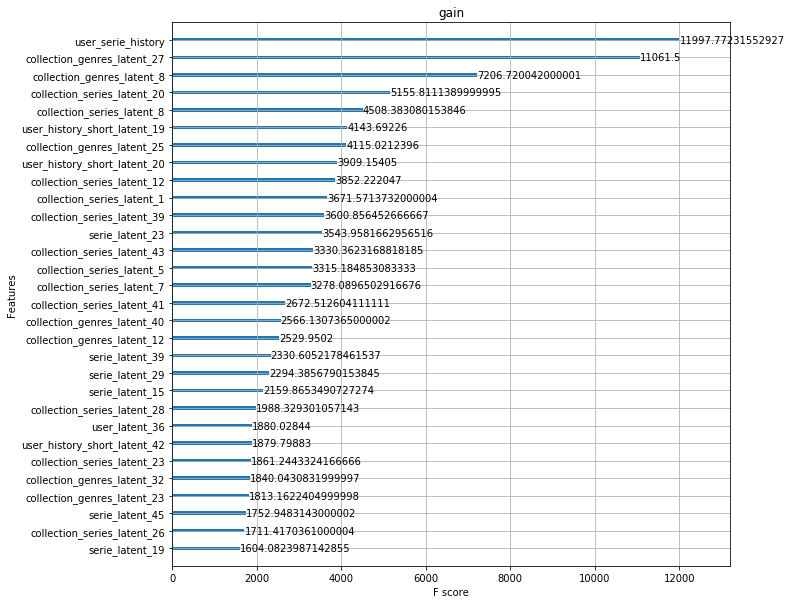

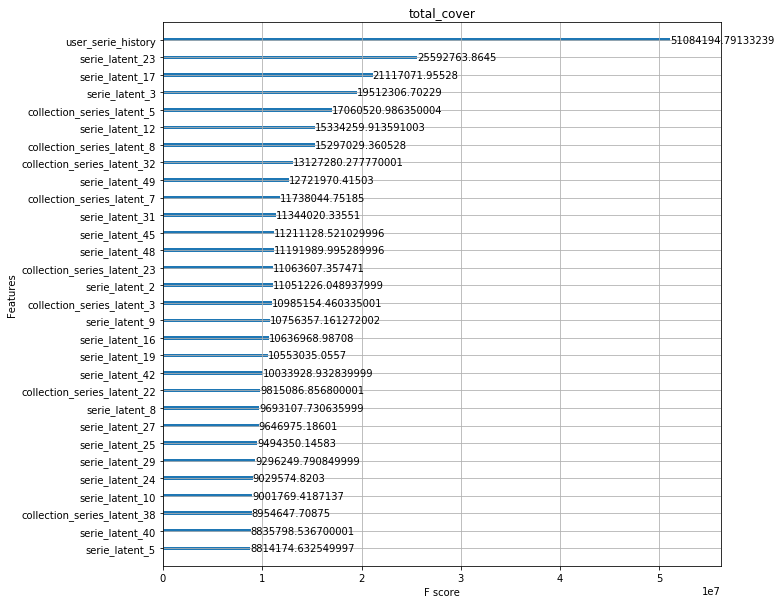

In [130]:
reg = joblib.load('V2_5.model')
reg.learner.model.feature_names = X_columns.tolist()

importance_types = ['weight', 'gain', 'cover', 'total_gain', 'total_cover']

for i, importance_type in enumerate(importance_types):
    f, a = plt.subplots(1,1, figsize=(10,10))
    xgb.plot_importance(reg.learner.model,  ax=a, importance_type=importance_type, max_num_features=30, title=importance_type)

In [3]:

for i, (name, theta) in enumerate(thetas.items()):
    if 'nogammainit' in name or 'multiclick' in name or 'long' in name or 'notheta' in name or 'eval' in name or 'lr' in name:
        continue
    np.save(f'{}')

[array([1.        , 0.5       , 0.33333333, 0.25      , 0.2       ,
        0.16666667, 0.14285714, 0.125     , 0.11111111, 0.1       ,
        0.09090909, 0.08333333, 0.07692308, 0.07142857, 0.06666667,
        0.0625    , 0.05882353, 0.05555556, 0.05263158, 0.05      ,
        0.04761905, 0.04545455, 0.04347826, 0.04166667, 0.04      ,
        0.03846154, 0.03703704, 0.03571429, 0.03448276, 0.03333333,
        0.03225806, 0.03125   , 0.03030303, 0.02941176, 0.02857143,
        0.02777778, 0.02702703, 0.02631579, 0.02564103, 0.025     ,
        0.02439024, 0.02380952, 0.02325581, 0.02272727, 0.02222222,
        0.02173913, 0.0212766 , 0.02083333, 0.02040816, 0.02      ,
        0.01960784, 0.01923077, 0.01886792, 0.01851852, 0.01818182,
        0.01785714, 0.01754386, 0.01724138, 0.01694915, 0.01666667,
        0.01639344, 0.01612903, 0.01587302, 0.015625  , 0.01538462,
        0.01515152, 0.01492537, 0.01470588]),
 array([1.        , 0.54933441, 0.39745182, 0.30600088, 0.25709795,
  

[array([1.        , 0.5       , 0.33333333, 0.25      , 0.2       ,
        0.16666667, 0.14285714, 0.125     , 0.11111111, 0.1       ,
        0.09090909, 0.08333333, 0.07692308, 0.07142857, 0.06666667,
        0.0625    , 0.05882353, 0.05555556, 0.05263158, 0.05      ,
        0.04761905, 0.04545455, 0.04347826, 0.04166667, 0.04      ,
        0.03846154, 0.03703704, 0.03571429, 0.03448276, 0.03333333,
        0.03225806, 0.03125   , 0.03030303, 0.02941176, 0.02857143,
        0.02777778, 0.02702703, 0.02631579, 0.02564103, 0.025     ,
        0.02439024, 0.02380952, 0.02325581, 0.02272727, 0.02222222,
        0.02173913, 0.0212766 , 0.02083333, 0.02040816, 0.02      ,
        0.01960784, 0.01923077, 0.01886792, 0.01851852, 0.01818182,
        0.01785714, 0.01754386, 0.01724138, 0.01694915, 0.01666667,
        0.01639344, 0.01612903, 0.01587302, 0.015625  , 0.01538462,
        0.01515152, 0.01492537, 0.01470588]),
 array([1.        , 0.54932993, 0.39746279, 0.30598058, 0.25708398,
  

[array([1.        , 0.5       , 0.33333333, 0.25      , 0.2       ,
        0.16666667, 0.14285714, 0.125     , 0.11111111, 0.1       ,
        0.09090909, 0.08333333, 0.07692308, 0.07142857, 0.06666667,
        0.0625    , 0.05882353, 0.05555556, 0.05263158, 0.05      ,
        0.04761905, 0.04545455, 0.04347826, 0.04166667, 0.04      ,
        0.03846154, 0.03703704, 0.03571429, 0.03448276, 0.03333333,
        0.03225806, 0.03125   , 0.03030303, 0.02941176, 0.02857143,
        0.02777778, 0.02702703, 0.02631579, 0.02564103, 0.025     ,
        0.02439024, 0.02380952, 0.02325581, 0.02272727, 0.02222222,
        0.02173913, 0.0212766 , 0.02083333, 0.02040816, 0.02      ,
        0.01960784, 0.01923077, 0.01886792, 0.01851852, 0.01818182,
        0.01785714, 0.01754386, 0.01724138, 0.01694915, 0.01666667,
        0.01639344, 0.01612903, 0.01587302, 0.015625  , 0.01538462,
        0.01515152, 0.01492537, 0.01470588]),
 array([1.        , 0.5493579 , 0.39747382, 0.3059867 , 0.25709657,
  

[array([1.        , 0.5       , 0.33333333, 0.25      , 0.2       ,
        0.16666667, 0.14285714, 0.125     , 0.11111111, 0.1       ,
        0.09090909, 0.08333333, 0.07692308, 0.07142857, 0.06666667,
        0.0625    , 0.05882353, 0.05555556, 0.05263158, 0.05      ,
        0.04761905, 0.04545455, 0.04347826, 0.04166667, 0.04      ,
        0.03846154, 0.03703704, 0.03571429, 0.03448276, 0.03333333,
        0.03225806, 0.03125   , 0.03030303, 0.02941176, 0.02857143,
        0.02777778, 0.02702703, 0.02631579, 0.02564103, 0.025     ,
        0.02439024, 0.02380952, 0.02325581, 0.02272727, 0.02222222,
        0.02173913, 0.0212766 , 0.02083333, 0.02040816, 0.02      ,
        0.01960784, 0.01923077, 0.01886792, 0.01851852, 0.01818182,
        0.01785714, 0.01754386, 0.01724138, 0.01694915, 0.01666667,
        0.01639344, 0.01612903, 0.01587302, 0.015625  , 0.01538462,
        0.01515152, 0.01492537, 0.01470588]),
 array([1.        , 0.54933738, 0.39746607, 0.30598082, 0.25709079,
  

[array([1.        , 0.5       , 0.33333333, 0.25      , 0.2       ,
        0.16666667, 0.14285714, 0.125     , 0.11111111, 0.1       ,
        0.09090909, 0.08333333, 0.07692308, 0.07142857, 0.06666667,
        0.0625    , 0.05882353, 0.05555556, 0.05263158, 0.05      ,
        0.04761905, 0.04545455, 0.04347826, 0.04166667, 0.04      ,
        0.03846154, 0.03703704, 0.03571429, 0.03448276, 0.03333333,
        0.03225806, 0.03125   , 0.03030303, 0.02941176, 0.02857143,
        0.02777778, 0.02702703, 0.02631579, 0.02564103, 0.025     ,
        0.02439024, 0.02380952, 0.02325581, 0.02272727, 0.02222222,
        0.02173913, 0.0212766 , 0.02083333, 0.02040816, 0.02      ,
        0.01960784, 0.01923077, 0.01886792, 0.01851852, 0.01818182,
        0.01785714, 0.01754386, 0.01724138, 0.01694915, 0.01666667,
        0.01639344, 0.01612903, 0.01587302, 0.015625  , 0.01538462,
        0.01515152, 0.01492537, 0.01470588]),
 array([1.        , 0.5493324 , 0.39746752, 0.30597591, 0.25708951,
  

[array([1.        , 0.5       , 0.33333333, 0.25      , 0.2       ,
        0.16666667, 0.14285714, 0.125     , 0.11111111, 0.1       ,
        0.09090909, 0.08333333, 0.07692308, 0.07142857, 0.06666667,
        0.0625    , 0.05882353, 0.05555556, 0.05263158, 0.05      ,
        0.04761905, 0.04545455, 0.04347826, 0.04166667, 0.04      ,
        0.03846154, 0.03703704, 0.03571429, 0.03448276, 0.03333333,
        0.03225806, 0.03125   , 0.03030303, 0.02941176, 0.02857143,
        0.02777778, 0.02702703, 0.02631579, 0.02564103, 0.025     ,
        0.02439024, 0.02380952, 0.02325581, 0.02272727, 0.02222222,
        0.02173913, 0.0212766 , 0.02083333, 0.02040816, 0.02      ,
        0.01960784, 0.01923077, 0.01886792, 0.01851852, 0.01818182,
        0.01785714, 0.01754386, 0.01724138, 0.01694915, 0.01666667,
        0.01639344, 0.01612903, 0.01587302, 0.015625  , 0.01538462,
        0.01515152, 0.01492537, 0.01470588]),
 array([1.        , 0.54935896, 0.39745899, 0.30598719, 0.25709478,
  